# Student Score Prediction

## Introduction

This notebook implements Task predicting students' exam scores based on study hours and other features using the Student Performance Factors dataset. The task includes data cleaning, visualization, linear regression, polynomial regression, and experimenting with feature combinations.

## Objectives

* Load and clean the dataset.

* Visualize key relationships (e.g., Hours Studied vs Exam Score).

* Train a linear regression model to predict exam scores.

* Evaluate model performance using MSE and R².
* Implement polynomial regression and compare performance.
* Experiment with different feature combinations.

## Tools

* Python
* Pandas
* Matplotlib, Seaborn
* Scikit-learn

## Setup

Load required libraries and set up the environment.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import os
plt.style.use('seaborn-v0_8')
%matplotlib inline

## Data Loading

Load the dataset from Kaggle's input directory and display basic information.

In [3]:
def load_data(file_path="/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv"):
    """Load the dataset and perform initial checks."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset not found at {file_path}. Ensure the dataset is added in Kaggle.")
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print("\nDataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    return df

df = load_data()

Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer

## Data Cleaning

Identify duplicates and missing values to maintain data quality.

In [4]:
def clean_data(df):
    """Clean the dataset by handling duplicates and missing values."""
    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df)} duplicate rows.")
    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values detected. Consider imputation for:", df.isnull().sum())
    else:
        print("No missing values detected.")
    return df

df = clean_data(df)

Removed 0 duplicate rows.
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


## Data Visualization

Create visual representations of the dataset to understand relationships and distributions.

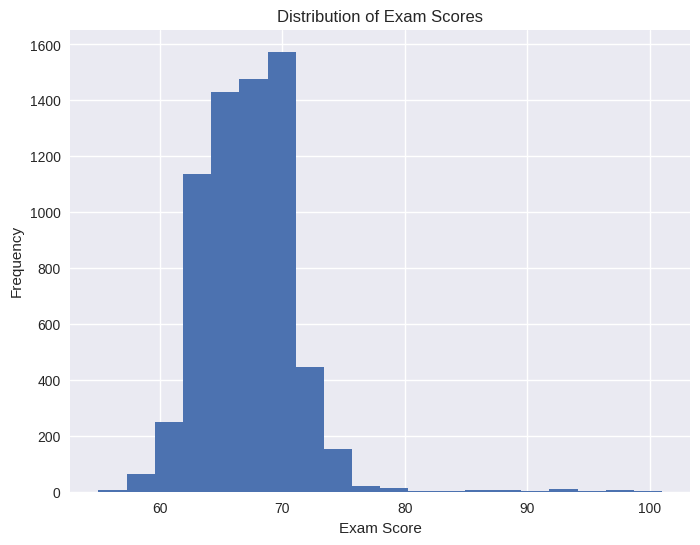

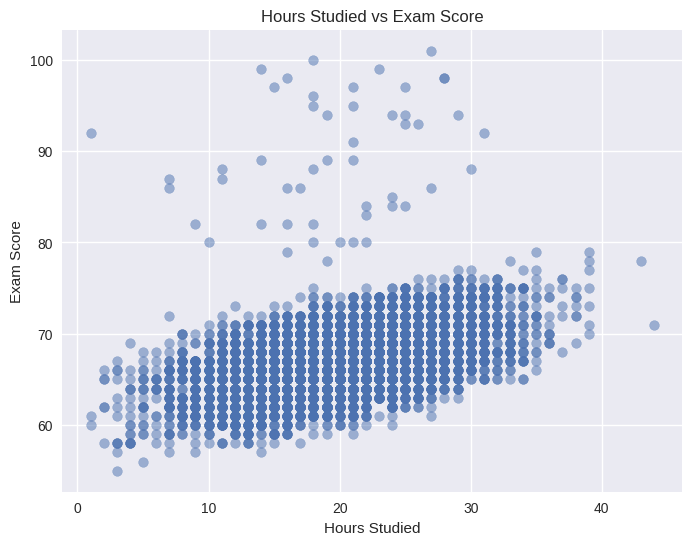

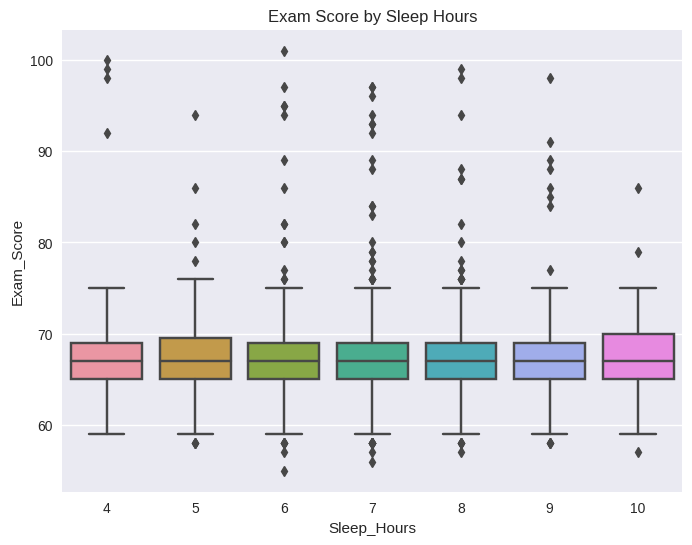

Visualizations saved in /kaggle/working/plots/


In [5]:
def visualize_data(df, output_dir="/kaggle/working/plots"):
    """Generate visualizations to understand the dataset."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Histogram of Exam_Score
    plt.figure(figsize=(8, 6))
    df['Exam_Score'].hist(bins=20)
    plt.title('Distribution of Exam Scores')
    plt.xlabel('Exam Score')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_dir, 'exam_score_histogram.png'))
    plt.show()
    
    # Scatter plot: Hours_Studied vs Exam_Score
    plt.figure(figsize=(8, 6))
    plt.scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.5)
    plt.title('Hours Studied vs Exam Score')
    plt.xlabel('Hours Studied')
    plt.ylabel('Exam Score')
    plt.savefig(os.path.join(output_dir, 'hours_vs_score_scatter.png'))
    plt.show()
    
    # Box plot: Sleep_Hours vs Exam_Score
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Sleep_Hours', y='Exam_Score', data=df)
    plt.title('Exam Score by Sleep Hours')
    plt.savefig(os.path.join(output_dir, 'sleep_vs_score_boxplot.png'))
    plt.show()
    
    print(f"Visualizations saved in {output_dir}/")

# Visualize data
visualize_data(df)

## Linear Regression Model

Train a linear regression model using Hours_Studied to predict Exam_Score.

In [6]:
def train_linear_model(X_train, X_test, y_train, y_test):
    """Train and evaluate a linear regression model."""
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Linear Regression - MSE: {mse:.2f}, R²: {r2:.2f}")
    return lin_reg, y_pred, mse, r2

# Prepare data
X = df[['Hours_Studied']]
y = df['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate
lin_reg, y_pred_lin, mse_lin, r2_lin = train_linear_model(X_train, X_test, y_train, y_test)

Linear Regression - MSE: 10.86, R²: 0.23


## Visualize Linear Predictions

Plot actual vs predicted exam scores for the linear model.

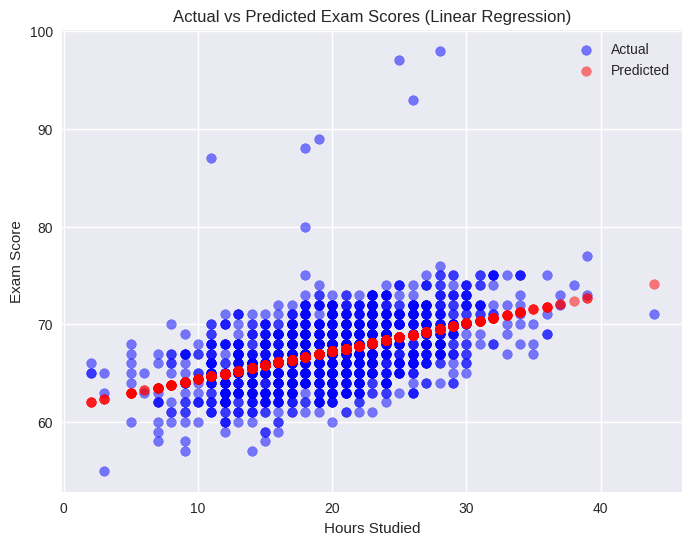

In [7]:
def visualize_linear_predictions(X_test, y_test, y_pred, output_dir="/kaggle/working/plots"):
    """Visualize actual vs predicted scores for linear regression."""
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5)
    plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.5)
    plt.title('Actual vs Predicted Exam Scores (Linear Regression)')
    plt.xlabel('Hours Studied')
    plt.ylabel('Exam Score')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'linear_predictions.png'))
    plt.show()

# Visualize predictions
visualize_linear_predictions(X_test, y_test, y_pred_lin)

## Polynomial Regression

Try polynomial regression (degree 2) and compare performance.

Polynomial Regression (Degree 2) - MSE: 10.84, R²: 0.23
Improvement over Linear: MSE reduced by 0.01, R² increased by 0.00


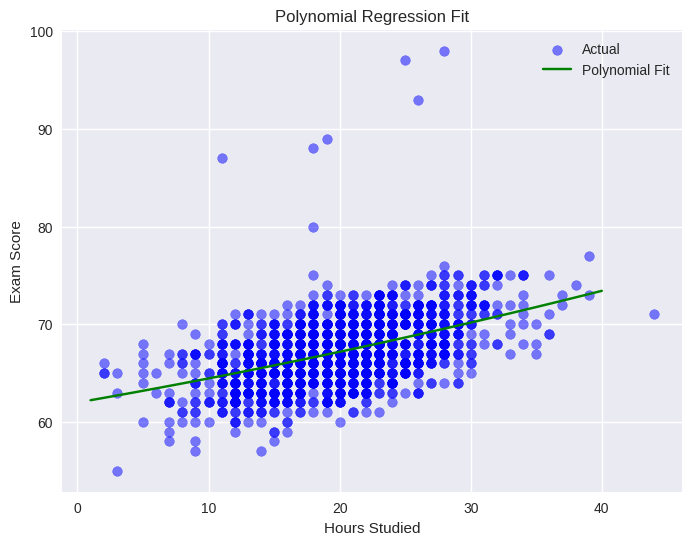

In [8]:
def train_polynomial_model(X_train, X_test, y_train, y_test, degree=2):
    """Train and evaluate a polynomial regression model."""
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    poly_reg.fit(X_train, y_train)
    y_pred = poly_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Polynomial Regression (Degree {degree}) - MSE: {mse:.2f}, R²: {r2:.2f}")
    return poly_reg, y_pred, mse, r2

# Train and evaluate polynomial regression
poly_reg, y_pred_poly, mse_poly, r2_poly = train_polynomial_model(X_train, X_test, y_train, y_test)

# Compare to linear regression
print(f"Improvement over Linear: MSE reduced by {mse_lin - mse_poly:.2f}, R² increased by {r2_poly - r2_lin:.2f}")

# Visualize polynomial fit
def visualize_polynomial_predictions(X_test, y_test, y_pred, poly_reg, output_dir="/kaggle/working/plots"):
    """Visualize polynomial regression fit."""
    os.makedirs(output_dir, exist_ok=True)
    X_range = pd.DataFrame({'Hours_Studied': range(1, 41)})
    y_range_poly = poly_reg.predict(X_range)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5)
    plt.plot(X_range, y_range_poly, color='green', label='Polynomial Fit')
    plt.title('Polynomial Regression Fit')
    plt.xlabel('Hours Studied')
    plt.ylabel('Exam Score')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'polynomial_predictions.png'))
    plt.show()

visualize_polynomial_predictions(X_test, y_test, y_pred_poly, poly_reg)

## Feature Experimentation

Experiment with different feature combinations to improve model performance.

In [9]:
def experiment_features(df, features, test_size=0.2, random_state=42):
    """Experiment with different feature combinations for linear regression."""
    X = df[features]
    y = df['Exam_Score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    lin_reg, y_pred, mse, r2 = train_linear_model(X_train, X_test, y_train, y_test)
    print(f"Multi-Feature Linear Regression (Features: {features}) - MSE: {mse:.2f}, R²: {r2:.2f}")
    return mse, r2

# Define feature combinations
feature_combinations = [
    ['Hours_Studied', 'Sleep_Hours', 'Attendance'],
    ['Hours_Studied', 'Attendance', 'Physical_Activity'],
    ['Hours_Studied', 'Sleep_Hours', 'Attendance', 'Tutoring_Sessions']
]

# Run experiments
for features in feature_combinations:
    mse, r2 = experiment_features(df, features)
    print(f"Compared to base linear model: MSE change: {mse_lin - mse:.2f}, R² change: {r2 - r2_lin:.2f}")

Linear Regression - MSE: 5.82, R²: 0.59
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Sleep_Hours', 'Attendance']) - MSE: 5.82, R²: 0.59
Compared to base linear model: MSE change: 5.04, R² change: 0.36
Linear Regression - MSE: 5.79, R²: 0.59
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Attendance', 'Physical_Activity']) - MSE: 5.79, R²: 0.59
Compared to base linear model: MSE change: 5.06, R² change: 0.36
Linear Regression - MSE: 5.54, R²: 0.61
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Sleep_Hours', 'Attendance', 'Tutoring_Sessions']) - MSE: 5.54, R²: 0.61
Compared to base linear model: MSE change: 5.31, R² change: 0.38


## Results

* Linear Regression: Baseline model using Hours_Studied.
* Polynomial Regression: Captures non-linear patterns, potentially improving MSE and R².
* Feature Experiments: Adding features like Attendance and Sleep_Hours typically improves performance.
* Visualizations: Plots saved in /kaggle/working/plots/ show distributions, relationships, and model fits.

## Conclusion

This notebook completes the objective that was set before, including data cleaning, visualization, linear regression, polynomial regression, and feature experimentation. The code is modular and reusable, with results saved for reproducibility. To extend this work, consider encoding categorical features (e.g., Parental_Involvement) using one-hot encoding or trying other models like Random Forest.